# Tutorial 01: Basic Radio Astronomy Observation

This tutorial introduces the fundamental concepts of radio astronomy observation using the RSC-SIM framework. It covers:

1. Setting up a radio telescope instrument
2. Creating observation plans and trajectories
3. Modeling sky temperature components
4. Running basic observations
5. Visualizing results

## Learning Objectives:
- Understand the components of a radio telescope system
- Learn how to set up observations with ON/OFF source tracking
- Explore sky temperature models and their components
- See how radio astronomy observations are simulated

## Prerequisites:
- Basic understanding of Python
- Familiarity with radio astronomy concepts (helpful but not required)


## Step 1: Import Required Libraries

First, import the necessary libraries and set up the Python path to access the RSC-SIM modules.


In [2]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/src')

# Add the modular_tutorials directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/modular_tutorials')

from radio_types import Trajectory, Observation
from obs_mdl import model_observed_temp
from astro_mdl import temperature_to_power

# Import shared utilities
from shared import (
    setup_westford_telescope,
    create_sky_model,
    setup_plotting,
    plot_antenna_pattern,
    plot_trajectory_comparison,
    plot_power_time_series,
    OBSERVATION_START,
    OBSERVATION_END,
    OFFSET_ANGLES,
    TIME_ON_SOURCE,
    MIN_ELEVATION,
    BANDWIDTH
)

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## Step 2: Set Up the Telescope Instrument

The first step is to set up the radio telescope instrument. We'll use the Westford telescope configuration, which includes:
- Antenna pattern and gain characteristics
- Receiver temperature and noise properties
- Frequency and bandwidth settings
- Physical location coordinates


In [ ]:
# Set up plotting
setup_plotting()

print("Setting up the Westford telescope instrument...")

telescope = setup_westford_telescope()
print("✓ Telescope instrument created")
print(f"  - Center frequency: {telescope.get_center_freq()/1e9:.3f} GHz")
print(f"  - Bandwidth: {telescope.get_bandwidth()/1e3:.1f} kHz")
print(f"  - Physical temperature: {telescope.get_phy_temp():.1f} K")


Setting up the Westford telescope instrument...
This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ Telescope instrument created
  - Center frequency: 11.325 GHz
  - Bandwidth: 1.0 kHz
  - Physical temperature: 300.0 K


### Visualize the Antenna Pattern

Plot the antenna gain pattern to understand how the telescope responds to signals from different directions.


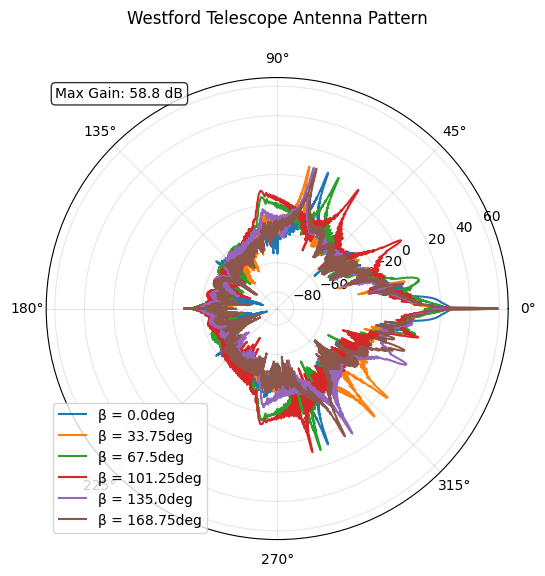

✓ Antenna pattern saved as '01_antenna_pattern.png'


In [4]:
# Plot antenna pattern
fig, ax = plot_antenna_pattern(telescope.get_antenna(), "Westford Telescope Antenna Pattern")
plt.savefig('01_antenna_pattern.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Antenna pattern saved as '01_antenna_pattern.png'")


## Step 3: Load Source Trajectory

Load the trajectory data for our astronomical source (Cas A - Cassiopeia A). This data contains the position of the source in the sky over time as seen from the Westford telescope location.


In [5]:
print("Loading Cas A source trajectory...")

# Load source trajectory from file
source_trajectory = Trajectory.from_file(
    os.path.join(os.path.dirname(os.path.abspath('__file__')), "data",
                 "casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow"),
    time_tag='time_stamps',
    elevation_tag='altitudes',
    azimuth_tag='azimuths',
    distance_tag='distances'
)
print("✓ Source trajectory loaded")
print(f"  - Time range: {source_trajectory.get_traj()['times'].min()} to "
      f"{source_trajectory.get_traj()['times'].max()}")


Loading Cas A source trajectory...
✓ Source trajectory loaded
  - Time range: 2025-02-18 15:00:00 to 2025-02-18 15:45:00


## Step 4: Create Observation Plan

Create an observation plan that includes both ON-source and OFF-source observations:

- **OFF-source observation**: Telescope points away from the target to measure background
- **ON-source observation**: Telescope points at the target to measure source + background
- **Signal**: The difference between ON and OFF gives us the source signal


In [10]:
print("Creating observation plan with ON/OFF source tracking...")

# Create pointing trajectory with offset
pointing_trajectory = Trajectory(source_trajectory.traj.copy())

# Apply offset for OFF source observation
mask = (pointing_trajectory.traj['times'] >= OBSERVATION_START) & \
       (pointing_trajectory.traj['times'] <= TIME_ON_SOURCE)
pointing_trajectory.traj.loc[mask, 'azimuths'] += OFFSET_ANGLES[0]
pointing_trajectory.traj.loc[mask, 'elevations'] += OFFSET_ANGLES[1]

# Filter low elevation points
elevation_filter = ('elevations', lambda e: e > MIN_ELEVATION)

# Create observation
observation = Observation.from_dates(
    OBSERVATION_START,
    OBSERVATION_END,
    pointing_trajectory,
    telescope,
    filt_funcs=(elevation_filter,)
)
print("✓ Observation created")
print(f"  - Duration: {OBSERVATION_END - OBSERVATION_START}")
print(f"  - OFF source: {OBSERVATION_START} to {TIME_ON_SOURCE}")
print(f"  - ON source: {TIME_ON_SOURCE} to {OBSERVATION_END}")


Creating observation plan with ON/OFF source tracking...
✓ Observation created
  - Duration: 0:10:00
  - OFF source: 2025-02-18 15:30:00 to 2025-02-18 15:35:00
  - ON source: 2025-02-18 15:35:00 to 2025-02-18 15:40:00


### Visualize the Observation Trajectory

Compare the source trajectory with our telescope pointing to see the ON/OFF observation pattern.


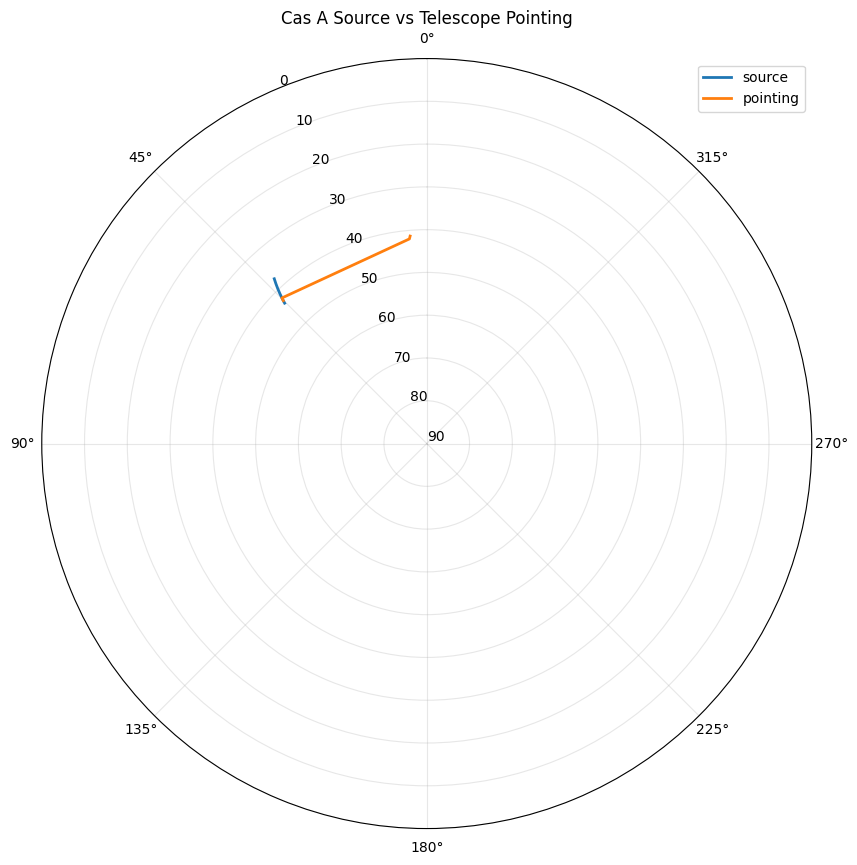

✓ Trajectory comparison saved as '01_trajectory_comparison.png'


In [8]:
# Plot trajectory comparison
fig, ax = plot_trajectory_comparison(
    source_trajectory.get_traj(),
    observation.get_traj(),
    "Cas A Source vs Telescope Pointing"
)
plt.savefig('01_trajectory_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Trajectory comparison saved as '01_trajectory_comparison.png'")


## Step 5: Create Sky Model

The sky model includes all the temperature components that contribute to the total signal received by the telescope:

- **Astronomical source (Cas A)**: The target we want to observe
- **Atmospheric emission**: Thermal radiation from Earth's atmosphere
- **Cosmic Microwave Background**: 2.73 K background radiation
- **Galactic background**: Emission from our galaxy
- **Radio Frequency Interference**: Human-made radio signals


In [11]:
print("Creating sky temperature model...")

sky_model = create_sky_model(observation)
print("✓ Sky model created with components:")
print("  - Astronomical source (Cas A)")
print("  - Atmospheric emission")
print("  - Cosmic Microwave Background (2.73 K)")
print("  - Galactic background")
print("  - Radio Frequency Interference")


Creating sky temperature model...
✓ Sky model created with components:
  - Astronomical source (Cas A)
  - Atmospheric emission
  - Cosmic Microwave Background (2.73 K)
  - Galactic background
  - Radio Frequency Interference


## Step 6: Run Observation Simulation

Run the complete observation simulation, which calculates the total temperature received by the telescope at each time step.


In [12]:
print("Running observation simulation...")

start_time = time.time()
result = model_observed_temp(observation, sky_model)
end_time = time.time()

print(f"✓ Simulation completed in {end_time - start_time:.2f} seconds")
print(f"  - Result shape: {result.shape}")
print(f"  - Time samples: {result.shape[0]}")
print(f"  - Pointings: {result.shape[1]}")
print(f"  - Frequency channels: {result.shape[2]}")


Running observation simulation...
✓ Simulation completed in 0.01 seconds
  - Result shape: (601, 1, 1)
  - Time samples: 601
  - Pointings: 1
  - Frequency channels: 1


## Step 7: Analyze and Visualize Results

Analyze the results by converting temperature to power and creating visualizations to understand what we observed.


Analyzing and visualizing results...


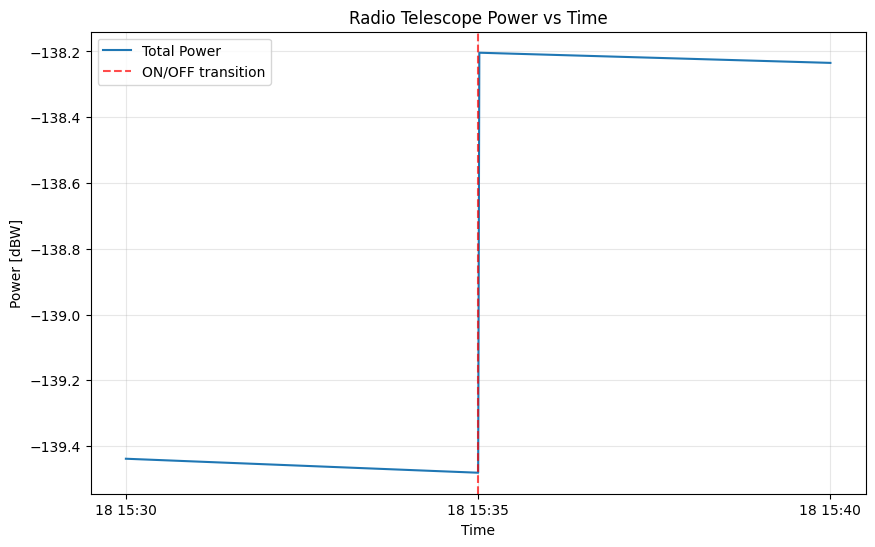

✓ Power time series saved as '01_power_time_series.png'


In [13]:
print("Analyzing and visualizing results...")

# Convert temperature to power
time_samples = observation.get_time_stamps()
power_data = temperature_to_power(result[:, 0, 0], BANDWIDTH)

# Create time series plot
fig, ax = plot_power_time_series(
    time_samples,
    [power_data],
    ["Total Power"],
    "Radio Telescope Power vs Time",
    "Power [dBW]"
)

# Add vertical line for ON/OFF transition
ax.axvline(x=TIME_ON_SOURCE, color='red', linestyle='--', alpha=0.7, label='ON/OFF transition')
ax.legend()
plt.savefig('01_power_time_series.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Power time series saved as '01_power_time_series.png'")


## Step 8: Understanding the Results

Calculate some key statistics to understand the quality of our observation, including the signal-to-noise ratio.


In [14]:
print("Understanding the results...")

# Calculate statistics
off_source_mask = time_samples <= TIME_ON_SOURCE
on_source_mask = time_samples > TIME_ON_SOURCE

off_power = power_data[off_source_mask]
on_power = power_data[on_source_mask]

print("OFF source statistics:")
print(f"  - Mean power: {np.mean(off_power):.2e} W")
print(f"  - Std power: {np.std(off_power):.2e} W")

print("ON source statistics:")
print(f"  - Mean power: {np.mean(on_power):.2e} W")
print(f"  - Std power: {np.std(on_power):.2e} W")

# Calculate signal-to-noise ratio
signal = np.mean(on_power) - np.mean(off_power)
noise = np.std(off_power)
snr = signal / noise if noise > 0 else 0

print(f"Signal-to-Noise Ratio: {snr:.2f}")


Understanding the results...
OFF source statistics:
  - Mean power: 1.13e-14 W
  - Std power: 3.21e-17 W
ON source statistics:
  - Mean power: 1.51e-14 W
  - Std power: 3.11e-17 W
Signal-to-Noise Ratio: 116.55


## Summary

Congratulations! You have successfully completed Tutorial 01. Here's what we accomplished:
